#### EDA for Global Energy Trends

This notebook builds on the preprocessing notebook (`01_preprocessing.ipynb`) to perform exploratory data analysis on the cleaned energy dataset.

#### Load Dataset

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

import os
import geopandas as gpd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from IPython.display import Image

# import seaborn as sns
# Set plot styles
# plt.style.use('seaborn-v0_8')
# sns.set_palette('husl')

In [13]:
# util funcs
def save_static_img(fig, filename):
    fig.write_image(f"{filename}")
    display(Image(f"{filename}"))

In [5]:
# Define directories
proj_dir =  os.path.dirname(os.getcwd())
processed_data_dir = os.path.join(proj_dir, 'data', 'processed')
figure_dir = os.path.join(proj_dir, 'figures')

# Load processed datasets
df = pd.read_parquet(os.path.join(processed_data_dir, 'imf_renewable_energy_v2.parquet'))  # Long-format energy data
df_countries = df[df['Region_type']=="Country"].copy()
df_aggregated_regions = df[df['Region_type']=="Aggregated Region"].copy()

# load geospatial data
geo_data = gpd.read_parquet(os.path.join(processed_data_dir, 'geo_data.geoparquet'))

print(f"Energy data shape: {df.shape}")
print(f"Geo data shape: {geo_data.shape}")

Energy data shape: (51575, 9)
Geo data shape: (177, 5)


#### Global Transition Narrative

In [3]:
# get world data only from df_aggregated_regions (filter for year 2000 to 2020 only)
world_energy = df_aggregated_regions[(df_aggregated_regions['Country']=='World') 
                                     & (df_aggregated_regions['Year'] >= 2000) 
                                     & (df_aggregated_regions['Year'] <= 2022)].copy()

# transform world_energy to have capacity and generation side by side
world_energy = world_energy\
    .groupby(['Year', 'Technology', 'Energy_Type', 'Indicator'], as_index=False)['Value'].sum()\
    .pivot_table(index=['Year', 'Technology', 'Energy_Type'],
                columns='Indicator',
                values='Value').reset_index()
world_energy.sample(3)

Indicator,Year,Technology,Energy_Type,Electricity Generation,Electricity Installed Capacity
43,2008,Solar energy,Total Renewable,1.275161e+04,1.523335e+04
48,2009,Solar energy,Total Renewable,2.094519e+04,2.355651e+04
76,2015,Fossil fuels,Total Non-Renewable,1.604392e+07,3.905916e+06


1. How has the share of renewable/non-renewable energy changed over time globally?

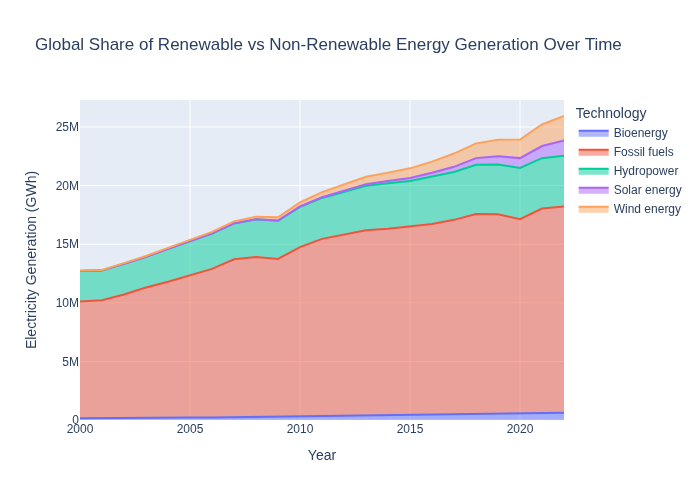

In [15]:
# Plot Global Electricity Generation Over Time
fig = px.area(world_energy, x='Year', y='Electricity Generation', color='Technology', line_group='Energy_Type',
                  title='Global Share of Renewable vs Non-Renewable Energy Generation Over Time')
fig.update_layout(xaxis_title='Year', yaxis_title='Electricity Generation (GWh)')
# fig.show() # for interactive image
save_static_img(fig, f"{figure_dir}/global_generation_share_over_time.png") # since github doesn't render px plots

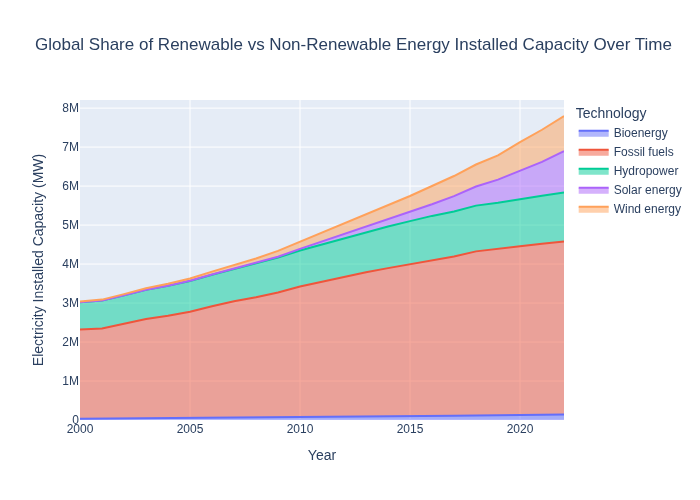

In [17]:
# Plot Global Electricity Generation Over Time
fig = px.area(world_energy, x='Year', y='Electricity Installed Capacity', color='Technology', line_group='Energy_Type',
                  title='Global Share of Renewable vs Non-Renewable Energy Installed Capacity Over Time')
fig.update_layout(xaxis_title='Year', yaxis_title='Electricity Installed Capacity (MW)')
# fig.show()
save_static_img(fig, f"{figure_dir}/global_capacity_share_over_time.png")

Fossil fuels have consistently dominated global electricity generation, contributing the largest share throughout the period for both installation & generation. We see rapid growth in the share of solar and wind energy technologies after 2010 reflecting aggressive global investment in those renewable technologies compared to Hydropower & bioenergy. 

However,the growth in renewable capacity is faster than the growth in renewable generation.

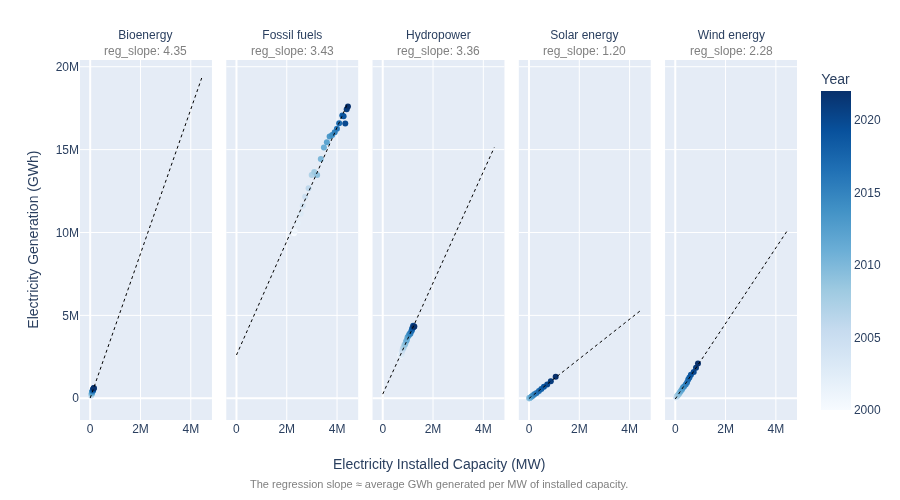

In [18]:
# Scatter Plot: Installed Capacity vs. Generation with Year-based Gradient
fig = px.scatter(world_energy, 
                 x='Electricity Installed Capacity', 
                 y='Electricity Generation', 
                 color='Year', 
                 color_continuous_scale='Blues',
                 facet_col='Technology', 
                 hover_data=['Year'],
                 width=900,
                 height=500)

# compute regression slopes for each tech
regression = {}   # {tech: (slope, intercept)}
for tech in world_energy['Technology'].unique():
    df_tech = world_energy[world_energy['Technology'] == tech]
    x = df_tech['Electricity Installed Capacity']
    y = df_tech['Electricity Generation']
    slope, intercept = np.polyfit(x, y, 1)
    regression[tech] = (slope, intercept)

# calculate global min & max for plotting line across this span
global_min = world_energy['Electricity Installed Capacity'].min()
global_max = world_energy['Electricity Installed Capacity'].max()


# add regression lines
for tech in world_energy['Technology'].unique():
    slope, intercept = regression[tech]
    df_tech = world_energy[world_energy['Technology'] == tech]

    # x_range = np.linspace(df_tech['Electricity Installed Capacity'].min(),
    #                       df_tech['Electricity Installed Capacity'].max(), 100)
    x_range = np.linspace(global_min, global_max, 200)
    y_pred = slope * x_range + intercept

    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_pred,
            mode='lines',
            line=dict(color='black', dash='dot', width=1),
            showlegend=False
        ),
        row=1,
        col=world_energy['Technology'].unique().tolist().index(tech) + 1
    )

for ann in fig.layout.annotations:
    if "Technology=" in ann.text:
        tech = ann.text.split("=")[1].strip() # shorten each tech title to fit on plot
        slope, _ = regression[tech]

        ann.text = (
            f"{tech}"
            f"<br><span style='font-size:12px; color:gray'>reg_slope: {slope:.2f}</span>"
        )


# remove auto axis titles
fig.update_xaxes(title_text=None)
fig.update_yaxes(title_text=None)

# add super labels
fig.add_annotation(
    text="Electricity Installed Capacity (MW)",
    xref="paper", yref="paper",
    x=0.5, y=-0.15,
    showarrow=False,
    font=dict(size=14)
)
fig.add_annotation(
    text="Electricity Generation (GWh)",
    xref="paper", yref="paper",
    x=-0.08, y=0.5,   # adjust x for left margin
    showarrow=False,
    textangle=-90,    # rotate text vertically
    font=dict(size=14)
)

fig.add_annotation(
    text="The regression slope ≈ average GWh generated per MW of installed capacity.",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,        # lower than the x‑axis label
    showarrow=False,
    font=dict(size=11, color="gray"),
    align="center"
)

# fig.update_layout(margin=dict(l=80, r=20, t=50, b=80))
# fig.show()
save_static_img(fig, f"{figure_dir}/capacity_vs_generation_trend.png")

#### Relationship Between Installed Capacity and Electricity Generation

Across all technologies, the scatterplots reveal a clear and consistent pattern: electricity generation increases as installed capacity grows. However, the rate at which generation scales with capacity—the **regression slope**—varies significantly by technology. These differences reflect underlying factors such as **capacity factors**, **dispatchability**, **resource variability**, and **technological maturity**.

---

**Bioenergy**

Bioenergy exhibits the **steepest slope** among all technologies, indicating the highest electricity output per MW of installed capacity. This is expected because bioenergy plants are **dispatchable**, operate independently of weather conditions, and typically run at **high utilization rates**, similar to conventional thermal plants. Although global bioenergy capacity is relatively small, its **per-MW productivity is exceptionally high**.

---

**Fossil Fuels**

Fossil fuel technologies show a **strong, tight linear relationship** between capacity and generation. Their slopes are high, reflecting **consistently high capacity factors** and **stable, controllable operation**. Both capacity and generation increase steadily over time, highlighting the continued reliance on fossil fuels during the period covered by the dataset.

---

**Hydropower**

Hydropower’s slope is comparable to fossil fuels, reflecting its **high efficiency** and ability to generate large amounts of electricity per MW. However, hydropower deployment is constrained by **geography**, **environmental impacts**, and **climate variability**. Droughts, rainfall anomalies, and ecological considerations limit the expansion of new hydropower installations despite its strong performance.

---

**Wind Energy**

Wind energy shows a **moderate slope**, lower than fossil fuels and hydropower. This reflects **wind variability**, **occasional curtailment**, and **grid integration challenges**. Even so, the upward progression of points over time indicates **rapid global expansion** of wind capacity, even if utilization rates remain lower than dispatchable technologies.

---

**Solar Energy**

Solar energy has the **lowest slope** among all technologies. This aligns with its inherently lower capacity factors due to **day–night cycles**, **seasonal variation**, and **weather dependence**. Despite this, the tight clustering of points suggests **predictable scaling**: as solar capacity increases, generation rises in a stable and consistent manner.

---

**Overall Insights**

- All technologies demonstrate a **positive linear relationship** between installed capacity and electricity generation.
- **Dispatchable technologies** (bioenergy, fossil fuels, hydropower) convert capacity into electricity more efficiently, reflected in higher slopes.
- **Variable renewables** (wind and solar) require more installed capacity to achieve the same level of generation due to intermittency.
- The **color gradient (years)** highlights a post-2010 structural shift, with rapid growth in wind and solar capacity driven by **global decarbonization efforts**.


---

## Note on Dataset Transition

This exploratory analysis was intentionally concluded early because, during the project, 
a more complete and higher‑quality dataset was identified. The new dataset offers:

- broader temporal and geographic coverage  
- more comprehensive energy categories  
- additional variables (e.g., energy demand, technology‑level metrics)  
- significantly fewer missing values  

To ensure the final analysis is as accurate and insightful as possible, the remaining EDA 
and modeling work will be continued in a new notebook using the improved dataset.

This notebook is preserved here to document the evolution of the project.